In [2]:
# !git clone https://github.com/epic-kitchens/epic-kitchens-100-annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from datetime import timedelta
import time

In [ ]:
print(np.load('tsm_noun_preds.npy').shape)
print(np.load('tsm_verb_preds.npy').shape)
print(np.load('sf_noun_preds.npy').shape)
print(np.load('sf_verb_preds.npy').shape)

(94032, 300)
(94032, 97)
(94860, 300)
(94860, 97)


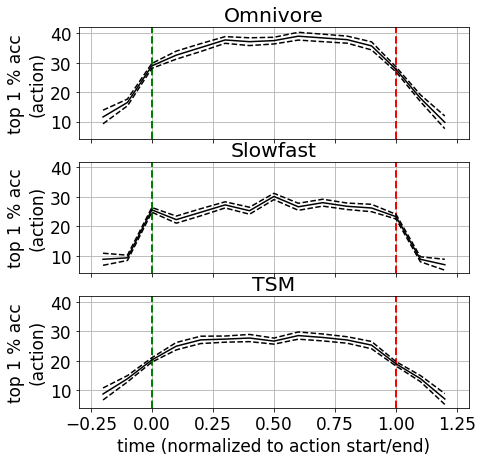

In [ ]:
font = {"family": "normal", "weight": "light", "size": 17}

rc("font", **font)


def timestamp_to_sec(timestamp):
    x = time.strptime(timestamp, "%H:%M:%S.%f")
    sec = (
        float(timedelta(hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds())
        + float(timestamp.split(".")[-1][:2]) / 100
    )
    return sec


action_labels = pd.read_csv("../data/epic-kitchens-100-annotations/EPIC_100_validation.csv")
action_labels.set_index("narration_id", inplace=True)

x_bins = np.arange(-0.2, 1.3, 0.1)

# fig, ax = plt.subplots(nrows=3,ncols=1)
plt.figure(figsize=(7, 7))
for j, npy_file in enumerate([["ov", 4], ["sf", 1], ["tsm", 4]]):
    verb_preds = np.load(f"{npy_file[0]}_verb_preds.npy")
    # verb_preds = softmax(verb_preds,axis=1)
    noun_preds = np.load(f"{npy_file[0]}_noun_preds.npy")
    # noun_preds = softmax(noun_preds,axis=1)
    val_videos = sorted(list(set(action_labels["video_id"])))

    video_durs = pd.read_csv("epic-kitchens-100-annotations/EPIC_100_video_info.csv")
    video_durs = dict(zip(video_durs["video_id"], video_durs["duration"]))
    video_durs = {k: v for k, v in video_durs.items() if k in val_videos}

    total_windows = 0
    video_offset = {}
    for k in video_durs.keys():
        video_offset[k] = total_windows
        total_windows += 1 + (video_durs[k] - npy_file[1]) // 0.5
    # print(total_windows)
    # print(verb_preds.shape)
    # input()

    # def get_action_frames_indices(video_record, min_time=2.0):

    # action_labels = action_labels[action_labels.index.str.startswith('P01_11')]

    action_agreement = []  # to determine action as verb+noun agreement
    for i, (target_class, target_preds) in enumerate([["verb_class", verb_preds], ["noun_class", noun_preds]]):
        xs = []
        ys = []

        # iterate over rows
        for _, video_record in action_labels.iterrows():
            offset = int(video_offset["_".join(_.split("_")[:2])])
            # print(_,offset,video_record)
            first_label_frame = (
                np.ceil(timestamp_to_sec(video_record.start_timestamp) / 0.5) * 0.5
            )  # hop size was always 0.5
            if first_label_frame < npy_file[1] / 2:
                continue
            last_label_frame = (
                np.floor(timestamp_to_sec(video_record.stop_timestamp) / 0.5) * 0.5
            )  # hop size was always 0.5
            if last_label_frame > video_durs[video_record["video_id"]] - npy_file[1]:
                continue
            action_start_index = int((first_label_frame - npy_file[1] / 2) / 0.5)
            action_stop_index = int((last_label_frame - npy_file[1] / 2) / 0.5)
            inside_action_indices = offset + np.arange(action_start_index, action_stop_index + 1)
            before_action_indices = offset + np.arange(
                action_start_index - int(len(inside_action_indices) / 5), action_start_index + 1
            )
            after_action_indices = offset + np.arange(
                action_stop_index, action_stop_index + 1 + int(len(inside_action_indices) / 5)
            )

            xs.extend(np.linspace(0, 1, len(inside_action_indices)))
            ys.extend(np.argmax(target_preds[inside_action_indices], axis=1) == video_record[target_class])

            if len(before_action_indices) > 0 and before_action_indices[0] >= offset:
                xs.extend(np.linspace(-0.2, 0, len(before_action_indices))[1:-1])
                ys.extend((np.argmax(target_preds[before_action_indices], axis=1) == video_record[target_class])[1:-1])
            if (
                len(after_action_indices) > 0
                and after_action_indices[-1] < offset + (video_durs[video_record["video_id"]] - npy_file[1]) / 0.5
            ):
                xs.extend(np.linspace(1.0, 1.2, len(after_action_indices))[1:-1])
                ys.extend((np.argmax(target_preds[after_action_indices], axis=1) == video_record[target_class])[1:-1])

        xs = np.array(xs)
        ys = np.array(ys)

        action_agreement.append(ys.copy())

        # y_vals = {}
        # for x in x_bins:
        #   y_vals[x] = ys[np.logical_and(xs>=(x-0.05),xs<(x+0.05))]

        # y_means = np.array([np.mean(v) for v in y_vals.values()])
        # y_std = np.array([np.std(v) for v in y_vals.values()])
        # # y_se = y_std/np.array([len(v) for v in y_vals.values()])
        # # print([len(v) for v in y_vals.values()])
        # # input()

        # plt.subplot(3,3,j*3+(i+1)+1)
        # if i==0:
        #   if npy_file[0] == 'tsm':
        #     plt.title('TSM\n'+f'{target_class.split("_")[0]}')
        #   elif npy_file[0] == 'sf':
        #     plt.title('Slowfast\n'+f'{target_class.split("_")[0]}')
        #   elif npy_file[0] == 'ov':
        #     plt.title('Omnivore\n'+f'{target_class.split("_")[0]}')
        # else:
        #   plt.title(target_class.split('_')[0])
        # rand_idx_select = np.random.choice(len(xs),100,replace=False)
        # plt.plot(x_bins,y_means,color='black')
        # plt.plot(x_bins,y_means+np.array(y_std),color='black', linestyle='--')
        # plt.plot(x_bins,y_means-np.array(y_std),color='black', linestyle='--')
        # plt.axvline(0,linestyle='--',color='green')
        # plt.axvline(1.0,linestyle='--',color='red')
        # plt.grid()
        # if j ==2:
        #   plt.xlabel('time (normalized to action start/end)')
        # plt.ylim([-0.3, 1.1])
        # plt.xlim([-0.3, 1.3])

    ys = np.array(np.logical_and(action_agreement[0], action_agreement[1]))

    y_vals = {}
    for x in x_bins:
        y_vals[x] = ys[np.logical_and(xs >= (x - 0.05), xs < (x + 0.05))]

    # y_means = [np.mean(v) for v in y_vals.values()]
    # y_std = [np.std(v) for v in y_vals.values()]
    y_means = np.array([np.mean(v) for v in y_vals.values()])
    y_std = np.array([np.std(v) for v in y_vals.values()])
    y_se = y_std / np.array([np.sqrt(len(v)) for v in y_vals.values()])

    plt.subplot(3, 1, j + 1)
    if npy_file[0] == "tsm":
        plt.title("TSM")
    elif npy_file[0] == "sf":
        plt.title("Slowfast")
    elif npy_file[0] == "ov":
        plt.title("Omnivore")
    plt.axvline(0, linestyle="--", color="green", linewidth=2.0)
    plt.axvline(1.0, linestyle="--", color="red", linewidth=2.0)
    plt.plot(x_bins, 100 * y_means, color="black")
    plt.plot(x_bins, 100 * (y_means + 1.96 * np.array(y_se)), color="black", linestyle="--")
    plt.plot(x_bins, 100 * (y_means - 1.96 * np.array(y_se)), color="black", linestyle="--")
    plt.grid()
    if j != 2:
        plt.xticks([-0.25, 0, 0.25, 0.5, 0.75, 1, 1.25], ["", "", "", "", "", "", ""])
    plt.yticks([10, 20, 30, 40], [10, 20, 30, 40])
    plt.ylabel("top 1 % acc\n(action)")
    plt.ylim([4, 42])
    plt.xlim([-0.3, 1.3])
    if j == 2:
        plt.xlabel("time (normalized to action start/end)")
plt.show()

turn-on tap 396


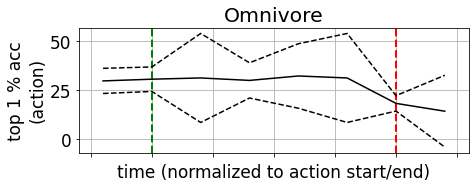


open cupboard 306


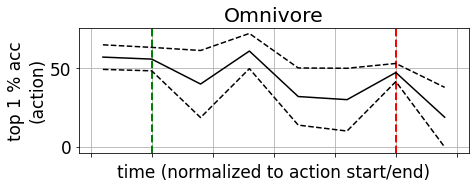


turn-off tap 294


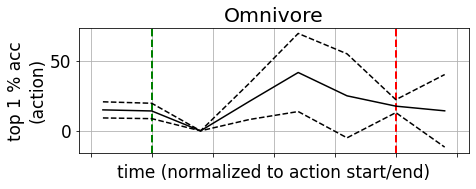


open drawer 290


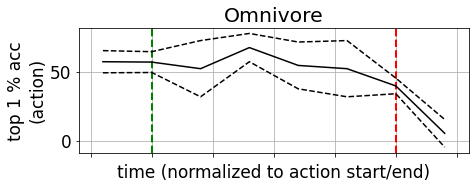


open fridge 230


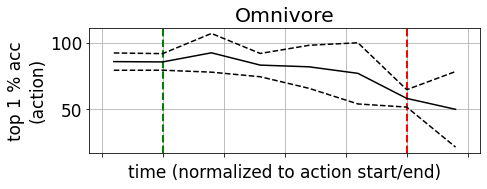


close cupboard 190


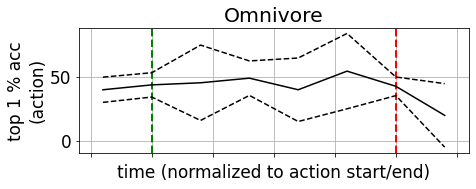


close drawer 176


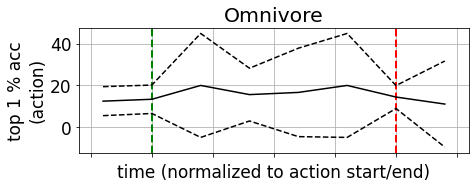


close fridge 160


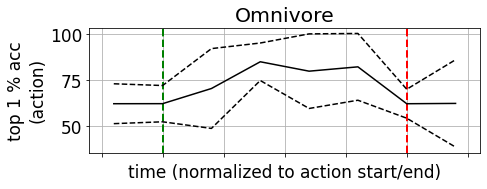


put-down knife 138


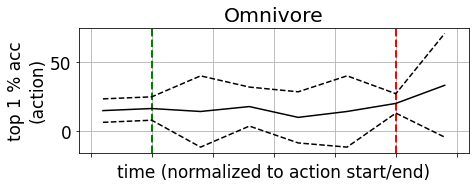


put-down plate 126


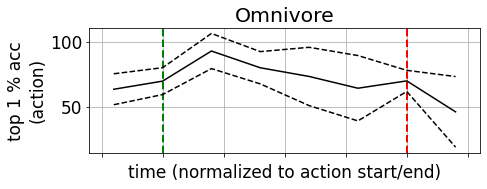


wash hand 118


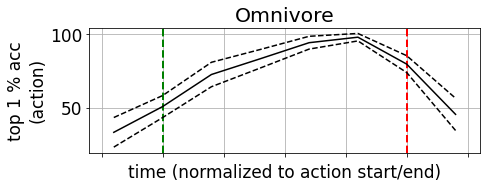


dry hand 118


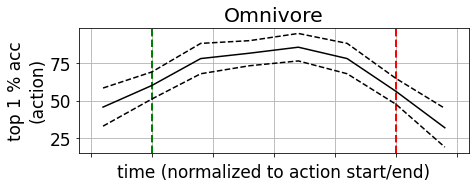


take plate 114


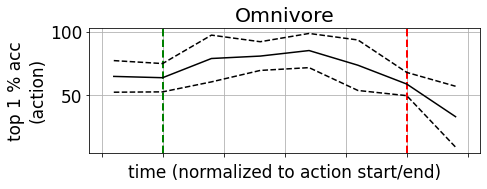


put-down spoon 106


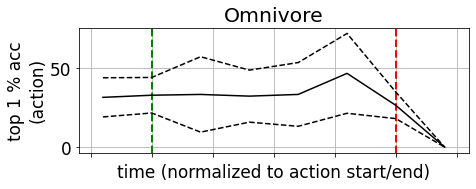


open door 102


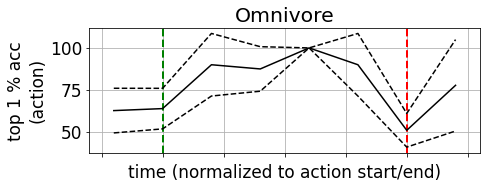


pick-up spoon 102


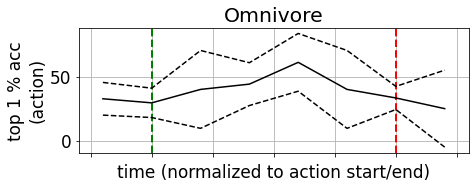


pick-up plate 96


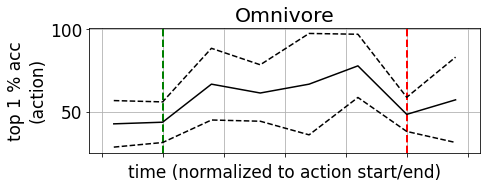


pick-up knife 94


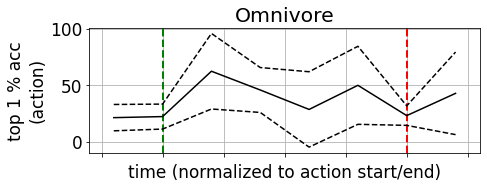


take knife 92


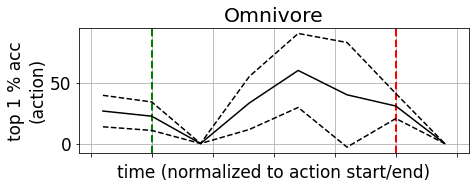


pick-up bowl 84


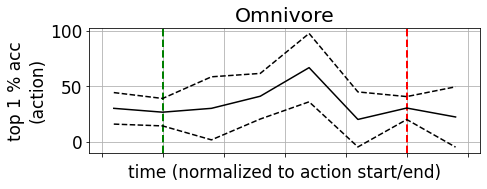


put-on lid 80


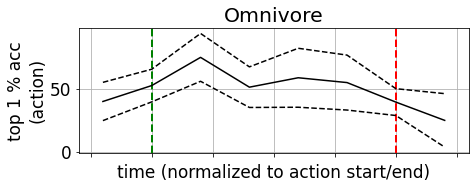


rinse plate 78


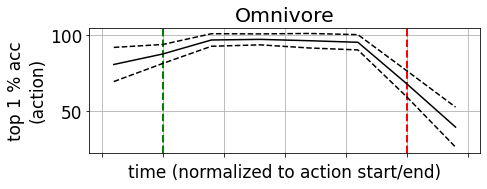


put-down fork 78


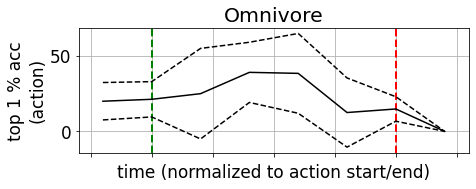


wash knife 76



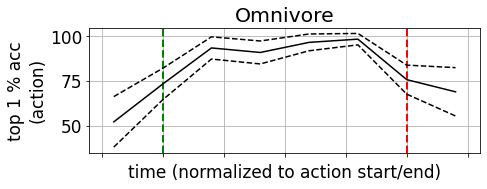

chop potato 74


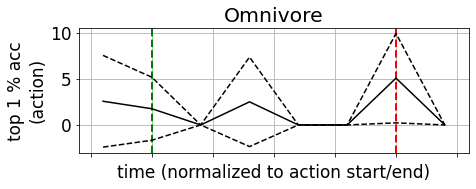


put-down spatula 74


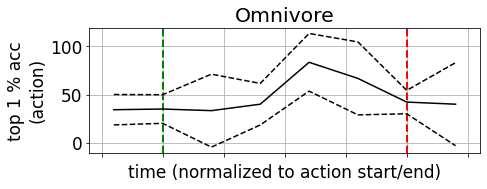


stir pasta 70


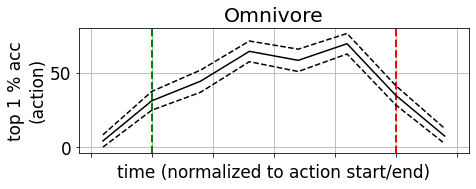


wash plate 70


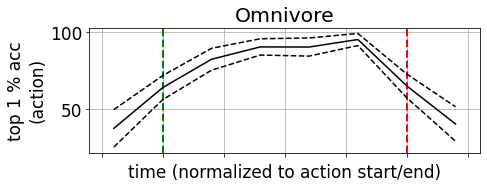


take spoon 68


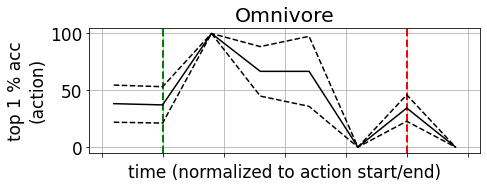


pick-up fork 64


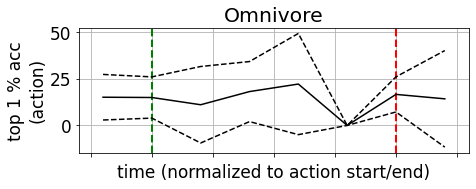


rinse hand 62


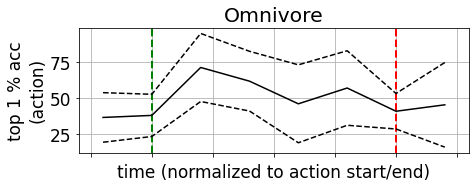


take spatula 60


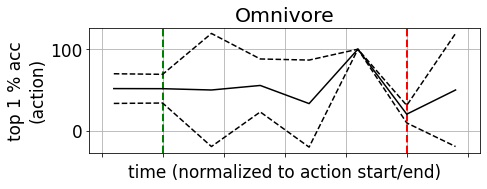


chop leek 58


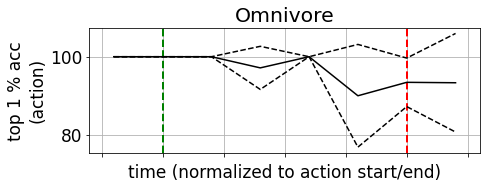


put-on plate 58


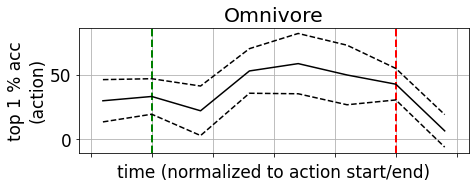


pour-into water 56


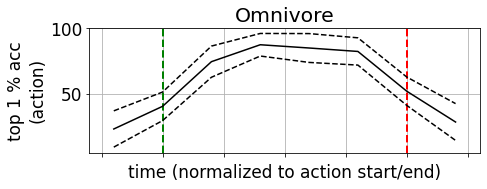


put spoon 54


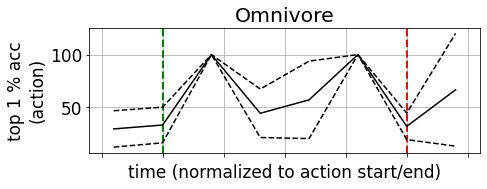


wash spoon 54


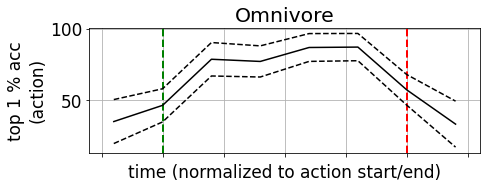


put-down bowl 52


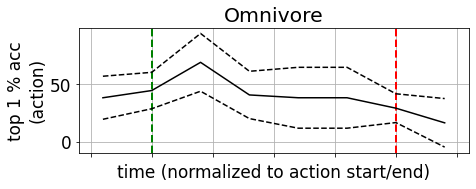


stir food 52


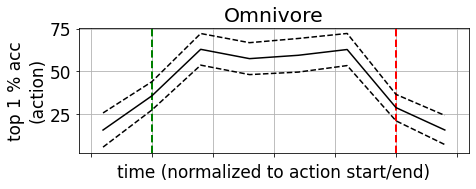


take bowl 52


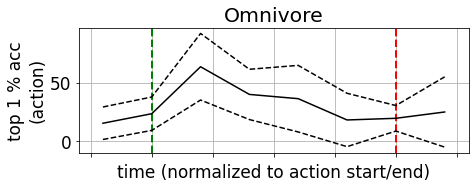


take fork 52


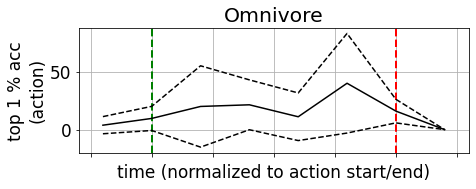


take sponge 52


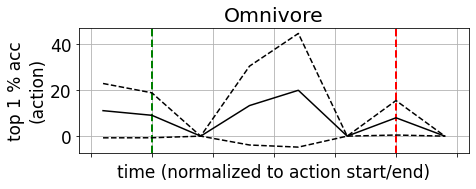


shake pan 50


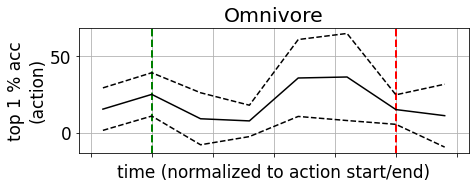


put-down glass 50


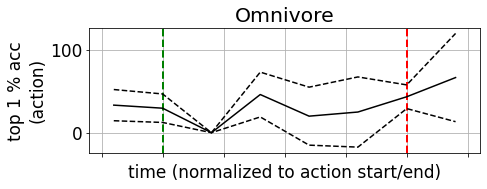


pick-up pan 48


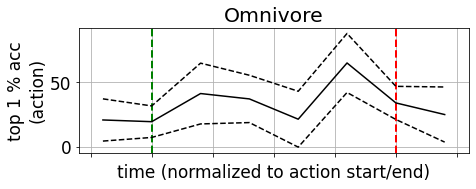


put-down pan 48


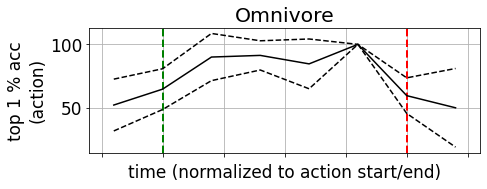


wash fork 48


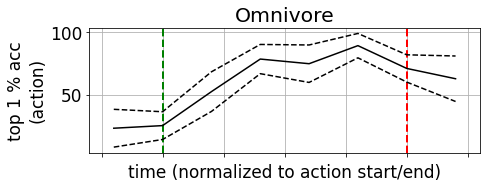


put-down lid 48


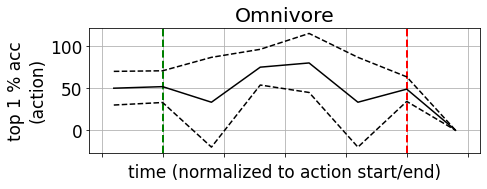


put-in mixture 46


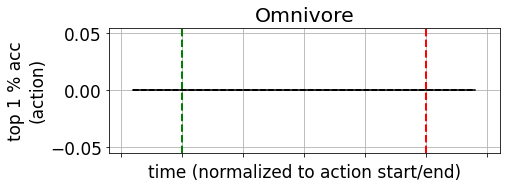


take mixture 46


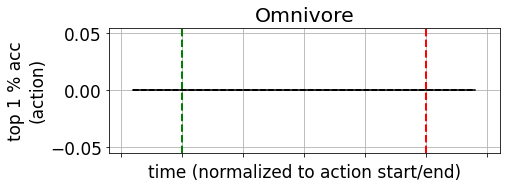


rinse knife 46


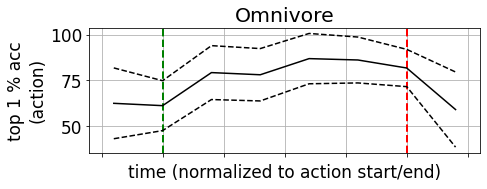


put-down sponge 46


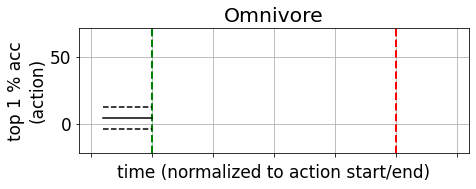


open bin 44


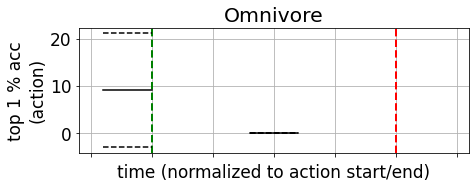


put-down cup 42


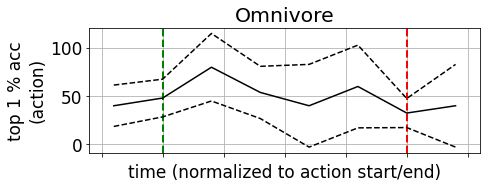


open cabinet 40


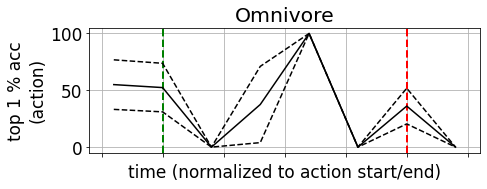


take-off lid 40


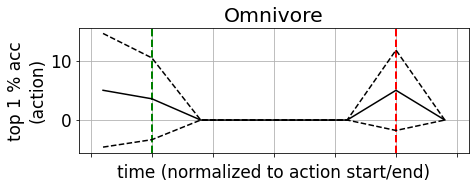


put-in bowl 40


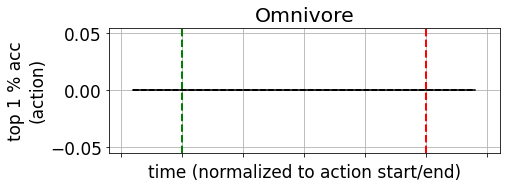


rinse sponge 40


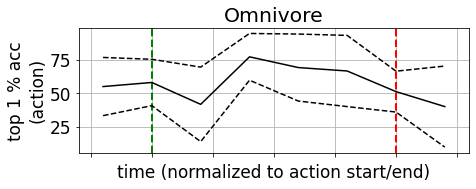

KeyboardInterrupt: ignored

In [ ]:
font = {'family' : 'normal',
        'weight' : 'light',
        'size'   : 17}

rc('font', **font)

def timestamp_to_sec(timestamp):
    x = time.strptime(timestamp, '%H:%M:%S.%f')
    sec = float(timedelta(hours=x.tm_hour,
                          minutes=x.tm_min,
                          seconds=x.tm_sec).total_seconds()) + float(
                                  timestamp.split('.')[-1][:2]) / 100
    return sec

action_labels = pd.read_csv('epic-kitchens-100-annotations/EPIC_100_validation.csv')
action_labels.set_index('narration_id',inplace=True)

x_bins = np.arange(-0.2,1.3,0.2)

# fig, ax = plt.subplots(nrows=3,ncols=1)
for j, npy_file in enumerate([['ov',4]]):
  verb_preds = np.load(f'{npy_file[0]}_verb_preds.npy')
  # verb_preds = softmax(verb_preds,axis=1)
  noun_preds = np.load(f'{npy_file[0]}_noun_preds.npy')
  # noun_preds = softmax(noun_preds,axis=1)
  val_videos = sorted(list(set(action_labels['video_id'])))

  video_durs = pd.read_csv('epic-kitchens-100-annotations/EPIC_100_video_info.csv')
  video_durs = dict(zip(video_durs['video_id'],video_durs['duration']))
  video_durs = {k:v for k,v in video_durs.items() if k in val_videos}

  total_windows = 0
  video_offset = {}
  for k in video_durs.keys():
    video_offset[k] = total_windows
    total_windows += 1 + (video_durs[k] - npy_file[1])//0.5
  # print(total_windows)
  # print(verb_preds.shape)
  # input()

  # def get_action_frames_indices(video_record, min_time=2.0):

  # action_labels = action_labels[action_labels.index.str.startswith('P01_11')]
  actions_dict = {}
  actions_count = {}
  for i, (target_class, target_preds) in enumerate([['verb_class',verb_preds],['noun_class',noun_preds]]):

    # iterate over rows
    for _,video_record in action_labels.iterrows():

      curr_act = '{} {}'.format(video_record.verb,video_record.noun)
      if curr_act not in actions_dict:
        actions_dict[curr_act] = [[[],[]],[[],[]]]
        actions_count[curr_act] = 1
      else:
        actions_count[curr_act] += 1
      offset = int(video_offset['_'.join(_.split('_')[:2])])

      first_label_frame = np.ceil(timestamp_to_sec(video_record.start_timestamp)/0.5)*0.5 # hop size was always 0.5
      if first_label_frame < npy_file[1]/2:
        continue
      last_label_frame = np.floor(timestamp_to_sec(video_record.stop_timestamp)/0.5)*0.5 # hop size was always 0.5
      if last_label_frame > video_durs[video_record['video_id']] - npy_file[1]/2:
        continue
      action_start_index = int((first_label_frame - npy_file[1]/2)/0.5)
      action_stop_index = int((last_label_frame - npy_file[1]/2)/0.5)
      inside_action_indices = offset + np.arange(action_start_index,action_stop_index+1)
      before_action_indices = offset + np.arange(action_start_index-int(len(inside_action_indices)/5), action_start_index+1)
      after_action_indices = offset + np.arange(action_stop_index,action_stop_index+1+int(len(inside_action_indices)/5))

      actions_dict[curr_act][i][0].extend(np.linspace(0,1,len(inside_action_indices)))
      actions_dict[curr_act][i][1].extend(np.argmax(target_preds[inside_action_indices],axis=1) == video_record[target_class])

      if len(before_action_indices)>0 and before_action_indices[0]>=offset:
        actions_dict[curr_act][i][0].extend(np.linspace(-0.2,0,len(before_action_indices)))
        actions_dict[curr_act][i][1].extend((np.argmax(target_preds[before_action_indices],axis=1) == video_record[target_class]))
      if len(after_action_indices)>0 and after_action_indices[-1]< offset+(video_durs[video_record['video_id']] - npy_file[1])/0.5:
        actions_dict[curr_act][i][0].extend(np.linspace(1.0,1.2,len(after_action_indices)))
        actions_dict[curr_act][i][1].extend((np.argmax(target_preds[after_action_indices],axis=1) == video_record[target_class]))

    actions_dict[curr_act][i][0] = np.array(actions_dict[curr_act][i][0])
    actions_dict[curr_act][i][1] = np.array(actions_dict[curr_act][i][1])


  actions_count = {k: v for k, v in reversed(sorted(actions_count.items(), key=lambda item: item[1]))}
  for k in actions_count.keys():
    v_ = actions_dict[k]
    print(k, actions_count[k])
    xs = v_[0][0]
    ys = np.array(np.logical_and(v_[0][1],v_[1][1]))

    y_vals = {}
    for x in x_bins:
      y_vals[x] = ys[np.logical_and(xs>=(x-0.1),xs<(x+0.1))]

    # y_means = [np.mean(v) for v in y_vals.values()]
    # y_std = [np.std(v) for v in y_vals.values()]
    y_means = np.array([np.mean(v) for v in y_vals.values()])
    y_std = np.array([np.std(v) for v in y_vals.values()])
    y_se = y_std/np.array([np.sqrt(len(v)) for v in y_vals.values()])

    plt.figure(figsize=(7,2.3))
    plt.title('Omnivore')
    plt.axvline(0,linestyle='--',color='green',linewidth=2.0)
    plt.axvline(1.0,linestyle='--',color='red',linewidth=2.0)
    plt.plot(x_bins,100*y_means,color='black')
    plt.plot(x_bins,100*(y_means+1.96*np.array(y_se)),color='black', linestyle='--')
    plt.plot(x_bins,100*(y_means-1.96*np.array(y_se)),color='black', linestyle='--')
    plt.grid()
    # if j != 2:
    plt.xticks([-0.25,0,0.25,0.5,0.75,1,1.25],['','','','','','',''])
    # plt.yticks([10,20,30,40],[10,20,30,40])
    plt.ylabel('top 1 % acc\n(action)')
    # plt.ylim([4, 42])
    plt.xlim([-0.3, 1.3])
    plt.xlabel('time (normalized to action start/end)')
    plt.show()
    input()

open fridge 230
wash hand 118
stir pasta 70
pour-into water 56
put-down spatula 74


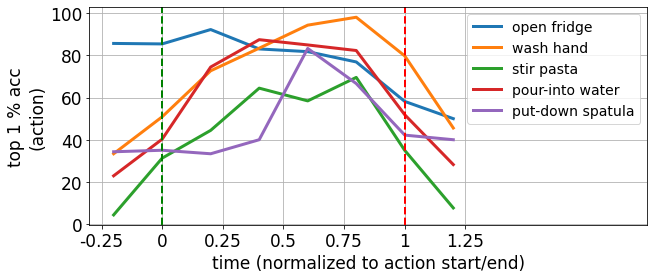

In [ ]:
# actions_count = {k: v for k, v in reversed(sorted(actions_count.items(), key=lambda item: item[1]))}
plt.figure(figsize=(10,4))
for k in ['open fridge','wash hand','stir pasta','pour-into water','put-down spatula']:
  v_ = actions_dict[k]
  print(k, actions_count[k])
  xs = v_[0][0]
  ys = np.array(np.logical_and(v_[0][1],v_[1][1]))

  y_vals = {}
  for x in x_bins:
    y_vals[x] = ys[np.logical_and(xs>=(x-0.1),xs<(x+0.1))]

  # y_means = [np.mean(v) for v in y_vals.values()]
  # y_std = [np.std(v) for v in y_vals.values()]
  y_means = np.array([np.mean(v) for v in y_vals.values()])
  y_std = np.array([np.std(v) for v in y_vals.values()])
  y_se = y_std/np.array([np.sqrt(len(v)) for v in y_vals.values()])

  plt.plot(x_bins,100*y_means,label=k,linewidth=3)
  # plt.plot(x_bins,100*(y_means+1.96*np.array(y_se)),color='black', linestyle='--')
  # plt.plot(x_bins,100*(y_means-1.96*np.array(y_se)),color='black', linestyle='--')
plt.grid()
# plt.yticks([10,20,30,40],[10,20,30,40])
plt.ylabel('top 1 % acc\n(action)')
# plt.ylim([4, 42])
plt.xlim([-0.3, 2])
plt.axvline(0,linestyle='--',color='green',linewidth=2.0)
plt.axvline(1.0,linestyle='--',color='red',linewidth=2.0)
plt.xticks([-0.25,0,0.25,0.5,0.75,1,1.25],[-0.25,0,0.25,0.5,0.75,1,1.25])
plt.legend(fontsize=14)
plt.xlabel('time (normalized to action start/end)')
plt.show()

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

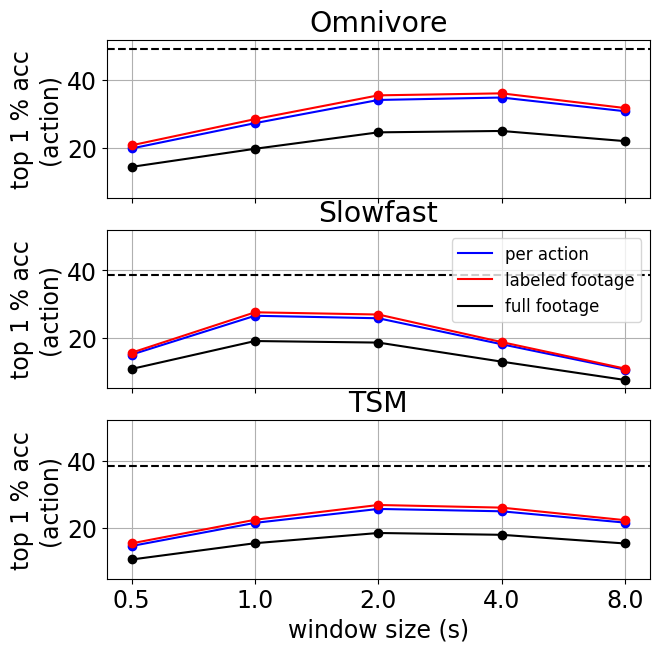

In [3]:
font = {"family": "normal", "weight": "light", "size": 17}

rc("font", **font)

o_w = [
    19.77,
    32.20,
    33.88,
    27.27,
    43.49,
    41.51,
    34.14,
    53.01,
    47.79,
    34.86,
    54.34,
    49.13,
    30.80,
    50.02,
    45.48,
]

o_w = np.array(o_w)
o_w = np.reshape(o_w, (5, 3))

s_w = [
    15.06,
    37.20,
    27.16,
    26.56,
    53.56,
    38.28,
    25.82,
    53.37,
    37.63,
    18.12,
    42.54,
    31.52,
    10.59,
    30.30,
    24.99,
]

s_w = np.array(s_w)
s_w = np.reshape(s_w, (5, 3))

t_w = [
    14.71,
    35.90,
    26.43,
    21.56,
    46.32,
    33.45,
    25.69,
    53.13,
    37.70,
    24.99,
    52.61,
    38.02,
    21.64,
    48.24,
    35.38,
]

t_w = np.array(t_w)
t_w = np.reshape(t_w, (5, 3))

o_s = [
    20.71,
    33.54,
    34.63,
    28.46,
    45.14,
    42.45,
    35.51,
    54.89,
    48.93,
    36.10,
    56.02,
    50.19,
    31.75,
    51.35,
    46.38,
]

o_s = np.array(o_s)
o_s = np.reshape(o_s, (5, 3))

s_s = [
    15.63,
    38.37,
    27.67,
    27.59,
    55.24,
    39.06,
    26.93,
    55.00,
    38.48,
    18.76,
    43.80,
    32.14,
    10.90,
    31.13,
    25.32,
]

s_s = np.array(s_s)
s_s = np.reshape(s_s, (5, 3))

t_s = [
    15.49,
    37.32,
    27.16,
    22.48,
    47.93,
    34.32,
    26.86,
    54.89,
    38.69,
    26.08,
    54.24,
    38.97,
    22.36,
    49.46,
    36.13,
]

t_s = np.array(t_s)
t_s = np.reshape(t_s, (5, 3))

o_f = [
    14.31,
    23.18,
    23.93,
    19.67,
    31.19,
    29.33,
    24.54,
    37.93,
    33.81,
    24.95,
    38.71,
    34.68,
    21.94,
    35.48,
    32.05,
]

o_f = np.array(o_f)
o_f = np.reshape(o_f, (5, 3))

s_f = [
    10.80,
    26.51,
    19.12,
    19.07,
    38.17,
    26.99,
    18.61,
    38.01,
    26.59,
    12.96,
    30.27,
    22.21,
    7.53,
    21.51,
    17.50,
]


s_f = np.array(s_f)
s_f = np.reshape(s_f, (5, 3))

t_f = [
    10.70,
    25.79,
    18.77,
    15.53,
    33.12,
    23.72,
    18.56,
    37.93,
    26.74,
    18.02,
    37.48,
    26.93,
    15.45,
    34.18,
    24.97,
]

t_f = np.array(t_f)
t_f = np.reshape(t_f, (5, 3))

model_names = ["Omnivore", "Slowfast", "TSM"]
model_quoted = [49.18, 38.53, 38.28]
experiments = ["per action", "labeled footage", "full footage"]

c = ["blue", "red", "black"]

plt.figure(figsize=(7, 7))
for j, data in enumerate([[o_w, o_s, o_f], [s_w, s_s, s_f], [t_w, t_s, t_f]]):
    plt.subplot(3, 1, j + 1)
    plt.title(f"{model_names[j]}")
    plt.axhline(model_quoted[j], linestyle="--", c="black")
    for i, d in enumerate(data):
        if j == 1:
            plt.plot(d[:, 0], c=c[i], label=f"{experiments[i]}")
            plt.legend(fontsize=12)
        else:
            plt.plot(d[:, 0], c=c[i])
        plt.plot(d[:, 0], "o", c=c[i])
        plt.grid(True)
        plt.ylim([5, 52])
        plt.ylabel("top 1 % acc\n(action)")
        if j != 2:
            plt.xticks(range(len(data[0])), ["", "", "", "", ""])
plt.subplot(3, 1, 3)
plt.xlabel("window size (s)")
plt.xticks(range(len(data[0])), ["0.5", "1.0", "2.0", "4.0", "8.0"])
plt.show()

In [1]:
font = {'family' : 'normal',
        'weight' : 'light',
        'size'   : 14}

rc('font', **font)


o_a = [49.18, 34.86, 36.10, 24.95]#34.24, 34.86, 34.59, 36.10, 25.00]#, 27.67,
# o_v = [68.21, ]#54.75, 54.34, 55.33, 56.03, 38.80]#, 43.79,
# o_n = [61.01, ]#47.45, 49.13, 47.82, 50.19, 34.76]#, 42.97,

s_a = [38.53, 26.56, 27.59, 19.07]#26.55, 26.56, 27.09, 27.59, 19.07]#23.62,
# s_v = [65.65, 54.12, 53.56, 55.10, 55.26, 38.19]#48.48,
# s_n = [50.01, 37.78, 38.28, 38.18, 39.04, 26.98]#36.47,

t_a = [38.28, 25.69, 26.86, 18.56]#26.73, 24.99, 27.09, 26.08, 18.56]# 21.20,
# t_v = [68.02, 56.78, 52.61, 57.39, 54.24, 37.93]# 44.81,
# t_n = [48.91, 37.79, 38.02, 38.17, 38.97, 26.74]#3 4.82,


c = ['blue','red','black']

model_names = ['Omnivore','Slowfast','TSM']

plt.figure(figsize=(7,5))
for i, data in enumerate([[o_a],[s_a],[t_a]]):
  # plt.subplot(1,3,1)
  plt.title('Action')
  plt.plot(data[0],label=f'{model_names[i]}',c=c[i])
  plt.plot(data[0],'o',c=c[i])

  plt.ylim([0,70])
  plt.xticks(range(len(data[0])),['original','per action', 'labeled footage', 'full footage'],rotation=45, ha='right')
  plt.ylabel('top 1 accuracy')
  plt.grid(True)
# plt.subplot(1,3,2)
plt.legend()
plt.xlabel('assumptions')
plt.savefig('task_complexity.png')
plt.show()

NameError: name 'rc' is not defined

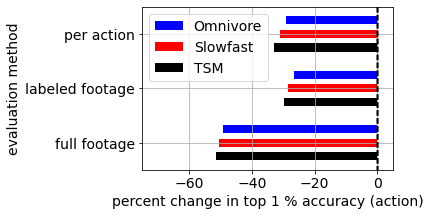

In [ ]:
def topercent(x):
  return -100*(x[0] - np.array(x))/x[0]

o_a_n = topercent(o_a)
s_a_n = topercent(s_a)
t_a_n = topercent(t_a)

c = ['blue','red','black']
model_names = ['Omnivore','Slowfast','TSM']
targets = ['action','verb','noun']

plt.figure(figsize=(4.5,3))
for j, d in enumerate([[o_a_n,s_a_n,t_a_n]]):
    for i, data in enumerate(d):
      # plt.subplot(1,3,1)
      # plt.title(targets[j])
      plt.barh(np.arange(i,len(data)*4,4),data, height=0.6,label=f'{model_names[i]}',color=c[i])
      plt.plot([0,0.1],[-100,100],'--k')
      plt.xlim([-75,5])
      plt.ylim([5,10])
      plt.yticks(np.arange(3,len(data)*4,4),['','','',''])
      # if j==1 and i==2:
      #   plt.legend()
      # elif j==0:
      plt.yticks(np.arange(5,len(data)*4,4),['per action', 'labeled footage', 'full footage'],ha='right')
      plt.ylabel('evaluation method')
      plt.xlabel('percent change in top 1 % accuracy (action)')
      plt.grid(True)
      plt.gca().invert_yaxis()
plt.legend()
plt.show()